In [169]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import warnings
pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
# Importing Training Set
dataset_train = pd.read_csv('maybe4.csv')
# Select features
cols = list(dataset_train)[1:4]
# getting daates
datelist_train = list(dataset_train['Dates'])
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (2892, 4)
All timestamps == 2892
Featured selected: ['XAU Curncy', 'USGG10YR Index', 'GLD US Equity']


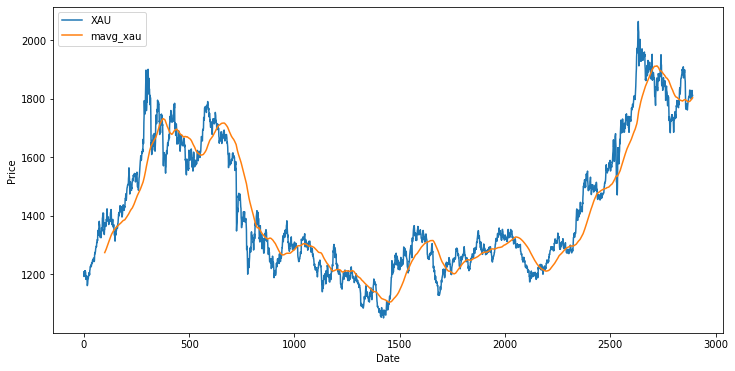

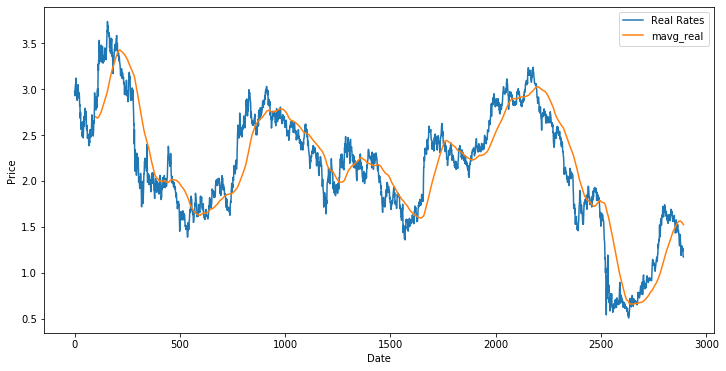

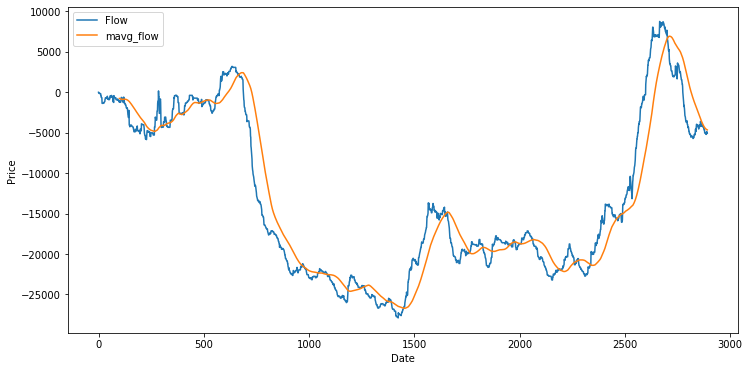

In [170]:
close_px = dataset_train['XAU Curncy']
last_px = dataset_train['USGG10YR Index']
flow_px = dataset_train['GLD US Equity']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='XAU')
mavg.plot(label='mavg_xau')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

mavg = last_px.rolling(window=100).mean()
plt.figure(figsize = (12,6))
last_px.plot(label='Real Rates')
mavg.plot(label='mavg_real')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

mavg = flow_px.rolling(window=100).mean()
plt.figure(figsize = (12,6))
flow_px.plot(label='Flow')
mavg.plot(label='mavg_flow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


In [171]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set
# Scaling
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

Shape of training set == (2892, 3).


array([[-0.92494939],
       [-0.99690335],
       [-0.95204779],
       ...,
       [ 1.74197361],
       [ 1.73880111],
       [ 1.72545019]])

In [172]:
# Creating a dataset with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60  # future prediction
n_past = 90     # lagged data

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2743, 90, 2).
y_train shape == (2743, 1).


Epoch 1/18
2743/2743 [==============================] - 5s 2ms/step - loss: 0.3858
Epoch 2/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.2158
Epoch 3/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1861
Epoch 4/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1730
Epoch 5/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1643
Epoch 6/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1500
Epoch 7/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1324
Epoch 8/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1295
Epoch 9/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1235
Epoch 10/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1234
Epoch 11/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1241
Epoch 12/18
2743/2743 [==============================] - 4s 1ms/step - loss: 0.1216
E

KeyError: 'val_loss'

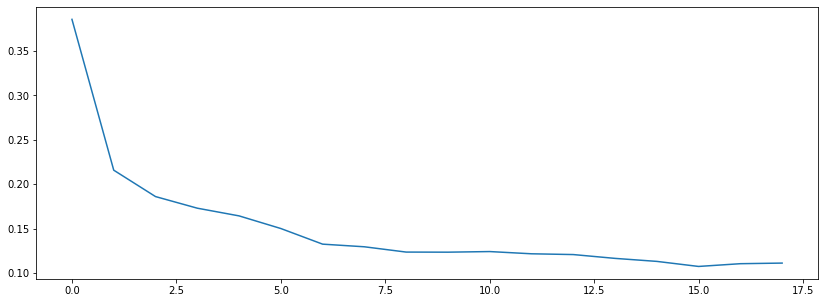

In [176]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
#model.summary()
history = model.fit(X_train, y_train, shuffle= True, epochs=18, validation_split = 0.0, verbose=1, batch_size=100)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

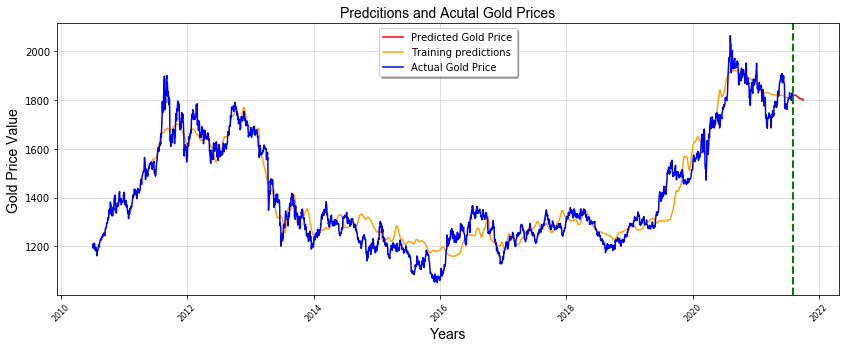

,Close
2021-07-28,1803.194824
2021-07-29,1802.730103
2021-07-30,1802.088379
2021-08-02,1801.142822
2021-08-03,1799.730103


In [186]:
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])
def datetime_to_timestamp(x):
     return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

pre_f = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))
pre_tr = pd.DataFrame(y_pred_train, columns=['Close']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))
pre_tr.index = pre_tr.index.to_series().apply(datetime_to_timestamp)
rcParams['figure.figsize'] = 14,5
# Plot parameters
plt.plot(pre_f.index, pre_f['Close'], color='r', label='Predicted Gold Price')
plt.plot(pre_tr.loc['07/05/2010':].index, pre_tr.loc['07/05/2010':]['Close'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc['07/05/2010':].index, dataset_train.loc['07/05/2010':]['XAU Curncy'], color='b', label='Actual Gold Price')

plt.axvline(x = min(pre_f.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.8)
plt.legend(shadow=True)
plt.title('Predcitions and Acutal Gold Prices', family='Arial', fontsize=14)
plt.xlabel('Years', family='Arial', fontsize=14)
plt.ylabel('Gold Price Value', family='Arial', fontsize=14)
plt.xticks(rotation=45, fontsize=8)
plt.show()
pre_tr.tail(5)